In [20]:
import os 
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy as sc
import pandas as pd
import tifffile 
from tifffile.tifffile import imread
import imageio
import cv2 as cv
import re

In [21]:
#establish prefix for files
data_path = '/SNS/VENUS/IPTS-35945/shared/images_normalized/Gd Mask Normalization' 
assert os.path.exists(data_path)

(512, 512)
float32


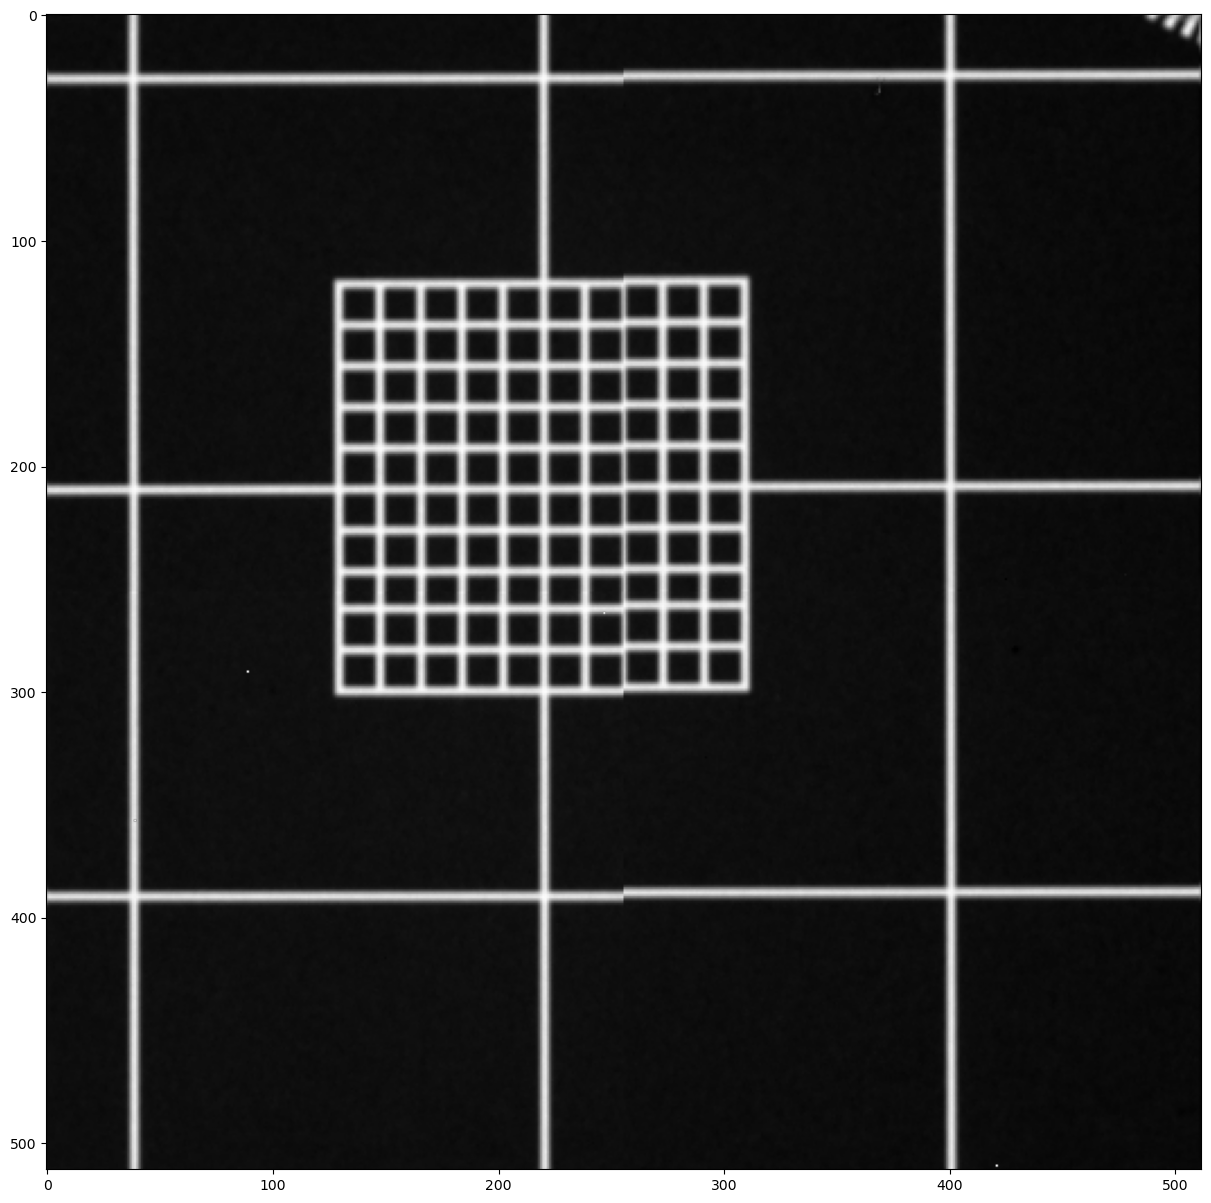

In [22]:
#display file dimension and data type (determine whether file is Float 32 and needs to be converted to uint8 [single channel unsigned])
img = imread(data_path+'/normalized_sample_7998_obs_8015/integrated.tif')
img.shape
fig,ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(img, cmap="gray")
print (img.shape)
print (img.dtype)

In [23]:
#files from TimePix1 will be Float32, and will need to undergo conversion to uint8
gray = cv.bitwise_not(img)
cv.normalize(gray, gray, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
gray_8bit =cv.convertScaleAbs(gray)

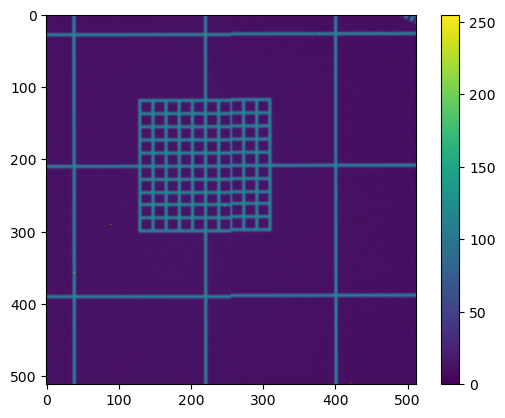

In [24]:
#establish source [src] file path, run through imread, plot
#gray_8bit = cv.imread(data_path+'/normalized_sample_7998_obs_8015/integrated.tif', cv.IMREAD_UNCHANGED)
plt.imshow(gray_8bit)
plt.colorbar()

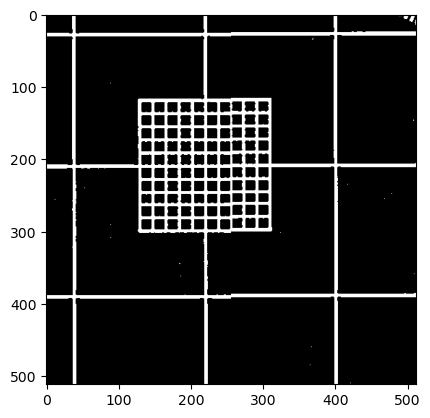

In [25]:
#Replots in true B/W -- notice introduction of artifacts
bw = cv.adaptiveThreshold(gray_8bit, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, -2)
plt.imshow(bw, cmap='gray')


In [26]:
#creates two separate images at highest contrast to separate horizontal and vertical features
horizontal = np.copy(bw)
vertical = np.copy(bw)

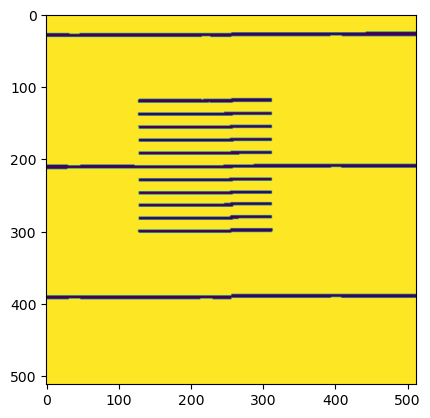

In [27]:
#horizontal processing -- separates and saves horizontal features
cols = horizontal.shape[1]
horizontal_size = cols // 30
horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size,1))
horizontal = cv.erode(horizontal, horizontalStructure)
horizontal = cv.dilate(horizontal, horizontalStructure)
horizontal = cv.bitwise_not(horizontal)
H_edges = cv.adaptiveThreshold(horizontal, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, -2)
kernel = np.ones((2,2),np.uint8)
H_edges = cv.dilate(H_edges, kernel)
smooth = np.copy(horizontal)
smooth = cv.blur(smooth, (2,2))
(rows,cols) = np.where(H_edges != 0)
horizontal [rows,cols] = smooth[rows, cols]
plt.imshow(horizontal)

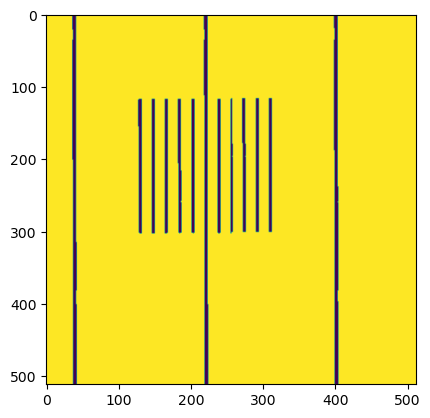

In [28]:
#vertical processing -- separates and saves vertical features
rows = vertical.shape[0]
verticalsize = rows // 30
verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1,verticalsize))
#vertical processing -- *enhance!*
vertical = cv.erode(vertical, verticalStructure)
vertical = cv.dilate(vertical, verticalStructure)
vertical = cv.bitwise_not(vertical)
V_edges = cv.adaptiveThreshold(vertical, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, -2)
kernel = np.ones((2,2),np.uint8)
V_edges = cv.dilate(V_edges, kernel)
smooth = np.copy(vertical)
smooth = cv.blur(smooth, (2,2))
(rows,cols) = np.where(V_edges != 0)
vertical [rows,cols] = smooth[rows, cols]
plt.imshow(vertical)


(512, 512)
(512, 512)


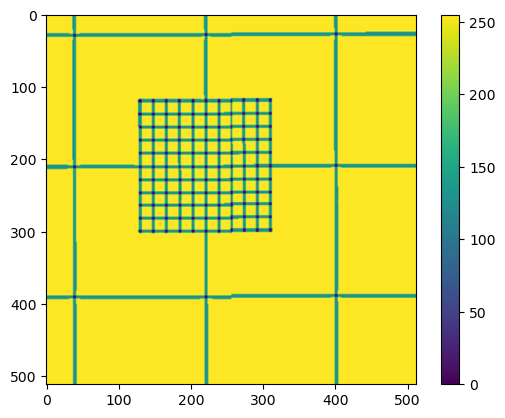

In [29]:
#Recombines the horizontal and vertical images into a single processed and edge-optimized image using 
#OpenCV "addWeighted" function
print (horizontal.shape)
print (vertical.shape)
alpha = .5
beta = 1-alpha
combined_image = cv.addWeighted(horizontal, alpha, vertical, beta, 0.0)
plt.imshow (combined_image)
plt.colorbar ()

(215, 130)


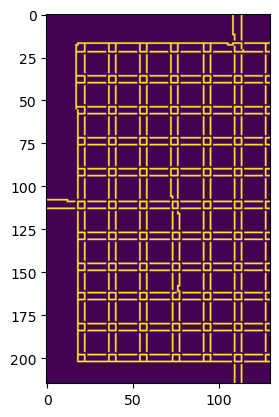

In [30]:
#Defines the ROI and processes the image to detect and identify the edges
x1,y1,width1,height1 =  110,100,130,215
roi_1=combined_image[y1:y1+height1,x1:x1+width1]
edges=cv.Canny(roi_1,0,150)
plt.imshow(edges)
print (edges.shape)
#add second ROI and plt.subplot to show two side-by-side excluding the issue area

In [31]:
#export the edge locations
edge_locations = np.column_stack(np.where(edges != 0))
edge_locations[:,0] += y1
edge_locations[:,1] += x1
np.savetxt('7998_edge_locations', edge_locations, fmt='%d', header = "Row, Column")






In [32]:
#establish individual 9x1 boxes along egdes to run through script
box_width = 9
left_range = 5
right_range = 3
boxes=[]
for (x1,y1) in edge_locations:
    left_edge=x1-left_range
    right_edge=x1+right_range
    box=(left_edge,y1, right_edge, y1)

    boxes.append(box)

boxes = np.array(boxes)
print(boxes)
np.savetxt('7998_edge_locations_boxes', boxes, fmt='%d', header = "Row, Column")

[[ 95 218 103 218]
 [ 95 223 103 223]
 [ 96 218 104 218]
 ...
 [308 223 316 223]
 [309 219 317 219]
 [309 223 317 223]]


In [ ]:
#Saves and iterates all saved ROIs through the resolution script
image=imageio.imread(data_path+'/normalized_sample_7998_obs_8015/integrated.tif')

for box in boxes:
    #establishes the box
    left_edge,y1,right_edge,y1=box
    roi = image[y1,left_edge:right_edge]
    #converts the ROI to dataframe to follow rest of program
    df_roi = pd.DataFrame(roi, columns=['Intensity'])
    df1 = df_roi["Intensity"]
    #finds derivative of edge spread function using NumPy gradient (small dataset)
    dydxdf = np.gradient(df1, 1)
    #Gaussian fit model
    #print (dydxdf)
    from numpy import loadtxt
    from lmfit.models import GaussianModel
    y = dydxdf
    x = np.arange(len(y))
    mod = GaussianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y,pars, x=x)
    print (out.fit_report(min_correl=.25))
    out.plot_fit()
    outputstring = out.fit_report(min_correl=.25)
    r_squared_G = r"R-squared\s*=\s*([0-9\.e\-]+)"
    FWHM_G = r"fwhm:\s*([\d\.e\-]+)"
    r_squared_match_G = re.search(r_squared_G, outputstring)
    r_squared_value_G = float(r_squared_match_G.group(1)) if r_squared_match_G else None
    FWHM_matches_G = re.search(FWHM_G, outputstring)
    fwhm_value_G = float(FWHM_matches_G.group(1)) if FWHM_matches_G else None
    #Lorentzian fit model
    from numpy import loadtxt
    from lmfit.models import LorentzianModel
    y = dydxdf
    x = np.arange(len(y))
    mod = LorentzianModel()
    pars = mod.guess(y, x=x)
    outL = mod.fit(y,pars, x=x)
    print (outL.fit_report(min_correl=.25))
    outL.plot_fit()
    outputstring = outL.fit_report(min_correl=.25)
    r_squared_L = r"R-squared\s*=\s*([0-9\.e\-]+)"
    FWHM_L = r"fwhm:\s*([\d\.e\-]+)"
    r_squared_match_L = re.search(r_squared_L, outputstring)
    r_squared_value_L = float(r_squared_match_L.group(1)) if r_squared_match_L else None
    FWHM_matches_L = re.search(FWHM_L, outputstring)
    fwhm_value_L = float(FWHM_matches_L.group(1)) if FWHM_matches_L else None
    #Voigt fit model
    from numpy import loadtxt
    from lmfit.models import VoigtModel
    y = dydxdf
    x = np.arange(len(y))
    mod = VoigtModel()
    pars = mod.guess(y, x=x)
    outV = mod.fit(y,pars, x=x)
    print (outV.fit_report(min_correl=.25))
    outV.plot_fit()
    outputstring = outV.fit_report(min_correl=.25)
    r_squared_V = r"R-squared\s*=\s*([0-9\.e\-]+)"
    FWHM_V = r"fwhm:\s*([\d\.e\-]+)"
    r_squared_match_V = re.search(r_squared_V, outputstring)
    r_squared_value_V = float(r_squared_match_V.group(1)) if r_squared_match_V else None
    FWHM_matches_V = re.search(FWHM_V, outputstring)
    fwhm_value_V = float(FWHM_matches_V.group(1)) if FWHM_matches_V else None
    #Determines best model fit by comparing R-squared values, selects that one to determine FWHM value from
    class Model:
        def __init__ (self, name ,r_squared, fwhm):
            self.name = name 
            self.r_squared = r_squared 
            self.fwhm = fwhm 
        def get_r_squared(self):
                return self.r_squared
        def get_fwhm(self):
              return self.fwhm
    ModelG = Model("Gaussian",r_squared_value_G,fwhm_value_G)
    ModelL = Model("Lorentzian", r_squared_value_L, fwhm_value_L)
    ModelV = Model("Voigt", r_squared_value_V, fwhm_value_V)
    models = [ModelG, ModelL, ModelV]
    best_model = max (models, key=lambda model: model.get_r_squared())
    pixel_density = .055 *best_model.get_fwhm() #mm
    print (f"The best fit for this data is the {best_model.name} fit with a R-squared value of {best_model.get_r_squared():.8f}.")
    print (f"The FWHM value of the {best_model.name} is {best_model.get_fwhm():.8f} pixels, yielding an empirical resolution of {pixel_density:.8f} millimeters.")

        
        
    '''plt.figure()
    plt.title('Grayscale Histgram for ROI')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frquency')
    plt.plot(bin_edges[0:-1], histogram)
    plt.xlim ([0,256])
    plt.show()'''

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 8
    # variables        = 3
    chi-square         = 1.2268e-05
    reduced chi-square = 2.4536e-06
    Akaike info crit   = -101.103610
    Bayesian info crit = -100.865285
    R-squared          = 0.27702290
[[Variables]]
    amplitude:  0.00490219 +/- 44.4884141 (907521.91%) (init = 0.04691505)
    center:     2.46373601 +/- 326.236267 (13241.53%) (init = 4)
    sigma:      0.28500218 +/- 1276.69734 (447960.55%) (init = 3)
    fwhm:       0.67112884 +/- 3006.39243 (447960.55%) == '2.3548200*sigma'
    height:     0.00686202 +/- 93.0134195 (1355482.46%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma)  = -1.0000
    C(amplitude, center) = +1.0000
    C(center, sigma)     = -1.0000
[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function

/tmp/ipykernel_3447418/1461433919.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(data_path+'/normalized_sample_7998_obs_8015/integrated.tif')


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8000
    # data points      = 8
    # variables        = 3
    chi-square         = 2.2578e-06
    reduced chi-square = 4.5156e-07
    Akaike info crit   = -114.644402
    Bayesian info crit = -114.406077
    R-squared          = 0.67280720
##  Warning: uncertainties could not be estimated:
[[Variables]]
    amplitude:  4.9444e+23 (init = 0.01056422)
    center:    -253.955397 (init = 0)
    sigma:      23.9244524 (init = 1.166667)
    fwhm:       56.3377790 == '2.3548200*sigma'
    height:     8.2448e+21 == '0.3989423*amplitude/max(1e-15, sigma)'
[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1045
    # data points      = 8
    # variables        = 3
    chi-square         = 2.0557e-06
    reduced chi-square = 4.1115e-07
    Akaike info crit   = -115.394573
    Bayesian info crit = -115.156248
    R-squared          = 

ValueError: could not convert string to float: '1.5569e'

Error in callback <function _draw_all_if_interactive at 0x7f2857b1f740> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
'''def zonal_resolution (x_left, x_right, y):
    cv.imread(img)
    roi = image [box]
    mask = cv.inRange(roi, 10, 255)
    histogram = cv.calcHist([img],[0], mask. [256],[0,256])
    plt.figure()
    plt.title('Grayscale Histgram for ROI')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frquency')
    plt.plot(histogram)
    plt.show()'''
    


SyntaxError: invalid syntax (3957556971.py, line 1)